In [1]:
# 코랩을 사용하지 않으면 이 셀의 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=7)

fatal: destination path 'nlp-with-transformers' already exists and is not an empty directory.
/home/jj/github/NLP/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.6.1
Using datasets v1.11.0


OSError: /home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/torchaudio/lib/libtorchaudio.so: undefined symbol: _ZNK2at10TensorBase8data_ptrIdEEPT_v

In [ ]:
import torch
torch.__version__

In [ ]:
import torchaudio
torchaudio.__version__

In [ ]:
%env TOKENIZERS_PARALLELISM=false

QA에는 여러종류가 있지만 가장 일반적인 방법은 문서에 있는 텍스트 일부를 질문의 답으로 추출하는  
추출적 QA(extractive QA)다.

관련된 문서를 추려내고 그 문서에서 원하는 답을 추출하는 두 단계 과정이 오늘날 QA 시스템의 기초가 된다.

이런 QA 시스템에는 '의미 검색 엔진', '지능형 비서', '자동화된 정보 추출기' 등이 있다.

여기서는 제품을 평가하기 위해 구체적인 질문을 하는 고객을 돕는 작업을 해보자

In [5]:
# haystack의 로깅을 끕니다.
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
               "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base",
               "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# 7.1 리뷰 기반 QA 시스템 구축하기

## 7.1.1 데이터셋
SubjQA (여섯 분야의 제품과 서비스에 10,000여개의 영어 고객 리뷰로 구성됨)  
tripAdvisor, 음식점, 영화, 책, 전자 제품, 식료품

closed-domain QA는 좁은주제 (단일 제품 카테고리 등)에 대한 질문을 다룬다.  
open-domain QA는 거의 모든 주제(아마존의 전체 제품 카탈로그 등)에 대한 질문을 다룬다.

In [6]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa") # 어떤 서브셋을 사용할 수 있는지 확인
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [7]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics") # 전자제품에 관한 subjqa 데이터셋 다운

#### SubjQA는 각 질문의 답을 중첩된 딕셔너리로 저장한다.

In [8]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


정답은 text 필드에 저장됨.  
answer_start에 시작 문자의 인덱스가 있다.  
이 데이터셋을 손쉽게 탐색하기 위해 flatten() 메서드로 중첩된 열을 펼치고 각 분할을 판다스 DataFrame로 변환

In [9]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items() :
    print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


In [10]:
dfs['train']

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.50,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4AA and QZ-99. The Koss Portapr...",How is the bass?,[],[],[],[],[]
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.50,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,"To anyone who hasn't tried all the various types of headphones, it is import...",Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as expected, even with EQ adjusted up]","[1302, 1302]","[1, 1]","[0.5083333, 0.5083333]","[True, True]"
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.50,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,"I have had many sub-$100 headphones from $5 Panasonic to $100 Sony, with Sen...",How is the bass?,[The only fault in the sound is the bass],[650],[2],[0.6333333],[True]
3,electronics,muddy,bass,awesome,bass,9876fd06ed8f075fcad70d1e30e7e8be,1,0.50,False,043e7162df91f6ea916c790c8a6f6b22,6895a59b470d8feee0f39da6c53a92e5,B00001WRSJ,"My sister's Bose headphones finally died and so, her being a super audiophil...",How is the audio bass?,[the best of all of them],[1609],[1],[0.3],[False]
4,electronics,perfect,bass,incredible,sound,16506b53e2d4c2b6a65881d9462256c2,1,0.65,True,29ccd7e690050e2951be49289e915382,7a2173c502da97c5bd5950eae7cd7430,B00001WRSJ,Wow. Just wow. I'm a 22 yr old with a crazy obsession with sound and music. ...,Why do I have an incredible sound?,"[The sound is so crisp, crazy obsession with sound and music]","[141, 38]","[1, 1]","[0.40833333, 0.40833333]","[False, False]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,electronics,great,impression,rubbery,feel,d4409d6272a7d1d5aa287d6e164bb7d0,1,0.00,False,ebaaec25661c0b21f3e5600a1ed7e30b,e0ea72e711324b5482ec1b36a48f16ee,B00H3OYSHW,I ordered my new NewTrend Airbender Pro NT610KR from Amazon. I received it ...,Where can I feel my device?,[],[],[],[],[]
1291,electronics,tight,case,great,protection,ed6533390fe2fe0d546b69dea570c34b,5,0.00,False,ebaaec25661c0b21f3e5600a1ed7e30b,ee5906ed3306b7c6d219a40adae2c7c2,B00H3OYSHW,I ordered my new NewTrend Airbender Pro NT610KR from Amazon. I received it ...,How does the selector protection me?,[],[],[],[],[]
1292,electronics,good,texture,good,grip,22b23446daf9d5bc0140be7278b220ee,1,0.00,False,84efbd9643d7f43af0ea0d2468c7dcc9,a541ffd9697ebf0ad9d226428594128e,B00HNGB1YS,"After using this case for a few days, I have grown to appreciate the designf...",How is the grip?,[],[],[],[],[]
1293,electronics,easy to use,keyboard,removable,keyboard,e7967ad5be0658b4acfca1118f6af1ab,1,0.00,False,e856d7e5351e3385b5d75f06562e905b,7efc5e7ffaa79f53cc50f76a44f9f88e,B00HPM1G8Q,Edit 4/21/14. I finally caved and purchased a Fire HDX to use with this keyb...,How is the keyboard?,"[the keyboard is very easy to use, the keyboard is very easy to use]","[258, 258]","[1, 1]","[1.0, 1.0]","[True, True]"


#### QA 시스템을 구축할 때 사용할 흥미로운 열을 선별하기
title : 각 제품에 연관된 ASIN Amazon Standard Identification Number  
question: 질문  
answers.text: 사람이 레이블링한 리뷰 텍스트 일부  
answers.answer_start  
context: 고객 리뷰

In [11]:
qa_cols = ["title", "question", "answers.text",
          "answers.answer_start", "context"]

sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


샘플의 특징  
1. 질문이 문법적으로 올바르지 않음  
2. answers.text 항목에는 리뷰에서 답을 찾지 못해 답변이 불가한 질문이 담김
3. 시작 인덱스와 답변 길이를 사용해 링뷰에서 답변에 해당하는 텍스트를 추출할 수 있다.

In [12]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

훈련 세트에 대략 어떤 종류의 질문이 있는지 알아보기 위해 몇 개의 흔한 단어로 시작하는 질문의 개수를 카운트해보자.

07/31/2023 21:17:06 - INFO - fontTools.subset -   maxp pruned
07/31/2023 21:17:06 - INFO - fontTools.subset -   cmap pruned
07/31/2023 21:17:06 - INFO - fontTools.subset -   kern dropped
07/31/2023 21:17:06 - INFO - fontTools.subset -   post pruned
07/31/2023 21:17:06 - INFO - fontTools.subset -   FFTM dropped
07/31/2023 21:17:06 - INFO - fontTools.subset -   GPOS pruned
07/31/2023 21:17:06 - INFO - fontTools.subset -   GSUB pruned
07/31/2023 21:17:06 - INFO - fontTools.subset -   glyf pruned
07/31/2023 21:17:06 - INFO - fontTools.subset -   Added gid0 to subset
07/31/2023 21:17:06 - INFO - fontTools.subset -   Added first four glyphs to subset
07/31/2023 21:17:06 - INFO - fontTools.subset -   Closing glyph list over 'GSUB': 36 glyphs before
07/31/2023 21:17:06 - INFO - fontTools.subset -   Glyph names: ['.notdef', '.null', 'D', 'F', 'H', 'I', 'Q', 'T', 'W', 'a', 'c', 'e', 'eight', 'f', 'five', 'four', 'h', 'i', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'q', 'r', 's', 'seven', 'six', '

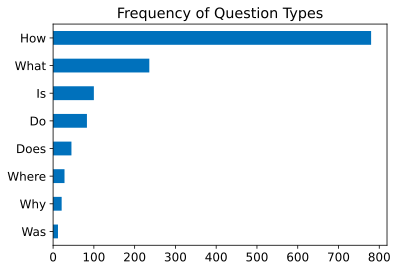

In [13]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
    # .str.startswith(q -> STR)는 string 안에 q가 있는지 없는지 체크하고 True, False로 반환
    
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

"How", "What", "Is"로 시작하는 질문이 가장 많다.

In [14]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)["question"]): # n개의 샘플 추출
            print(question)
            

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


## 7.1.2 텍스트에서 답 추출하기

QA 시스템에서는 가장 먼저 고객 리뷰에 있는 텍스트에서 답변에 사용할 만한 부분을 식별해 낼 방법을 찾아야 한다.  
ex) 'Is it waterproof?'라는 질문에 'This watch is waterproof at 30m depth'라는 리뷰가 있다면, 모델은 'waterproof at 30m'를 출력한다.

#### 이렇게 하려면 다음 방법을 이해해야 한다.
1. 지도 학습 문제로 구성하기
2. QA 작업을 위해 텍스트를 토큰화하고 인코딩하기
3. 모델의 최대 문맥 크기를 초과하는 긴 텍스트 다루기

### 지도 학습 문제로 구성하기 -> 범위 분류
문제를 범위 분류(span classification) 작업으로 구성하는 방법은 텍스트에서 답을 추출하는 가장 일반적인 방법이다.  
이 작업에서 모델이 예측해야 하는 레이블은 답변 범위에 해당하는 시작 토큰과 종료 토큰이다.  

#### 추출적 QA는 레이블 구조가 데이터셋에 달라지지 않기 떄문에 미세 튜닝한 모델로 시작해도 된다.
(2장에서는 클래스 개수가 현재 데이터셋과 달라서 분류 헤드를 미세 튜닝해야 했음.)

#### MiniLM 모델은 훈련 속도가 높아서 빠르게 반복하며 여러 기술을 살펴보기 좋다. -> 이걸 사용

### QA를 위한 텍스트 토큰화
텍스트를 인코딩할 토크나이저가 가장 먼저 필요하다.  
텍스트를 인코딩하기 위해 허깅페이스 허브에서 MiniLM 모델의 체크포인트를 로드

In [15]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [16]:
# 모델 한 번 작동해보기 ㅋㅋ

question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [17]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [18]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


token_type_ids 텐서는 입력에서 어떤 부분이 질문과 문맥에 해당하는지 나타낸다.  
(0은 질문 토큰, 1은 문맥 토큰을 나타낸다.)

#### ※ token_type_ids가 모든 트랜스포머 모델에 있는 것은 아님.  
-> MiniLM 같은 BERT 유사 모델의 경우 사전 훈련하는 동안 다음 문장 예측 작업을 통합하기 위해 token_type_ids를 사용하기도 한다.

In [19]:
# 토크나이저가 QA 작업에서 입력을 포맷팅하는 방법 확인

print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


#### QA 샘플마다 다음 포맷으로 입력이 구성된다.
[CLS] 질문 토큰 [SEP] 문맥 토큰 [SEP]

#### 첫 번째 [SEP]토큰의 위치는 token_type_ids에 의해 결정된다.  
텍스트를 토큰화했으니 QA 헤드와 함께 모델 객체를 초기화하고 입력을 정방향 패스에 통과시킨다.

In [20]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


#### QA 헤드는 QuestionAnsweringModelOutput 객체를 출력한다.  
헤드는 인코더의 은닉 상태를 받아 시작과 종료 범위의 로짓을 계산하는 선형 층에 해당한다.(자세한건 2장에서 함)  
이는 QA 작업을 4장의 개체명 인식과 비슷하게 토큰 분류 형태로 다룬다는 의미다.

출력을 답의 범위로 변환하기 위해 먼저 시작과 종료 토큰의 로짓이 필요함.

In [21]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

이 로짓의 크기를 입력 ID와 비교해보자.

In [22]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


시작과 종료 로짓은 각 입력 토큰에 연관된다.  
큰 양수 로짓은 가능성이 높은 시작과 종료 토큰 후보에 해당한다.  

07/31/2023 21:17:10 - INFO - fontTools.subset -   maxp pruned
07/31/2023 21:17:10 - INFO - fontTools.subset -   cmap pruned
07/31/2023 21:17:10 - INFO - fontTools.subset -   kern dropped
07/31/2023 21:17:10 - INFO - fontTools.subset -   post pruned
07/31/2023 21:17:10 - INFO - fontTools.subset -   FFTM dropped
07/31/2023 21:17:10 - INFO - fontTools.subset -   GPOS pruned
07/31/2023 21:17:10 - INFO - fontTools.subset -   GSUB pruned
07/31/2023 21:17:10 - INFO - fontTools.subset -   glyf pruned
07/31/2023 21:17:10 - INFO - fontTools.subset -   Added gid0 to subset
07/31/2023 21:17:10 - INFO - fontTools.subset -   Added first four glyphs to subset
07/31/2023 21:17:10 - INFO - fontTools.subset -   Closing glyph list over 'GSUB': 41 glyphs before
07/31/2023 21:17:10 - INFO - fontTools.subset -   Glyph names: ['.notdef', '.null', 'C', 'E', 'L', 'P', 'S', 'a', 'b', 'bracketleft', 'bracketright', 'c', 'comma', 'd', 'e', 'f', 'five', 'g', 'h', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o

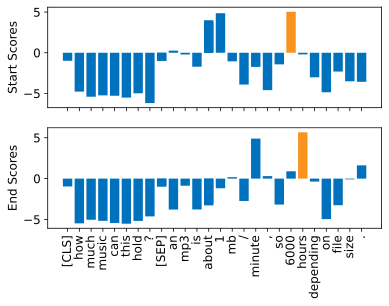

In [23]:
# 시작 토큰과 종료 토큰에 대한 예측 로짓. 오렌지 색 토큰이 가장 높은 점수를 가진 토큰입니다.
# 이 그래프는 다음을 참고했습니다. https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT

import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if e != np.max(e_scores) else "C1" for e in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

이 예시에서는 숫자 1과 6,000에 가장 높은 시작 토큰 로짓을 할당했다. 질문이 어떤 양에 관한 것이므로 이해된다.  
마찬가지로 로짓이 가장 높은 종료 토큰은 'minute'와 'hours'다.

최종 답을 얻기 위해 시작 토큰과 종료 토큰의 로짓에 argmax 함수를 적용하고 입력에서 이 범위를 슬라이싱한다.  
다음 코드는 이런 단계를 수행하고 결과를 디코딩해 텍스트로 출력한다.

In [24]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold?
답변: 6000 hours


#### 트랜스포머스는 편리하게 이런 모든 전처리 단계와 후처리 단계가 전용 파이프라인 안에 있다.
다음처럼 토크나이저와 미세 튜닝된 모델을 전달해 파이프라인을 초기화한다.

In [25]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

[{'score': 0.26516255736351013,
  'start': 38,
  'end': 48,
  'answer': '6000 hours'},
 {'score': 0.2208293378353119,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253478586673737,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

답변 외에도, 이 파이프라인은 (로짓에 소프트맥스 함수를 적용해) 모델이 추정한 확률을 score 필드로 제공한다.  
한 문맥에서 여러 답을 비교할 때 편리함.  
또 topk 매개변수를 사용하면 모델이 여러 개의 답을 예측한다.  

answers.answer_start가 비어있는 SubjQA 샘플처럼 이따금 답변이 불가한 질문도 있다.  
모델은 이러한 경우 [CLS] 토큰에 높은 시작 점수와 종료 점수를 할당한다.  
파이프라인은 이 출력을 빈 문자열로 매핑한다.

In [26]:
pipe(question="Why is there no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9068408012390137, 'start': 0, 'end': 0, 'answer': ''}

이 예에서는 간단히 해당 로짓에 argmax를 적용해 시작과 종료 인덱스를 얻었다.  
하지만 이 방법은 문맥 대신 질문에 속한 토큰을 선택해서 범위가 벗어난 답을 생성할 때도 있다.  
실전에서는 범위 내에 있는지, 시작 인덱스가 종료 인덱스 앞에 있는지 등의 다양한 제약 조건을 따라 파이프라인이 최상의 시작 인덱스와 종료 인덱스의 조합을 계산한다.

### 긴 텍스트 다루기
독해 모델의 결점 하나는 종종 문맥에 있는 토큰이 모델의 최대 시퀀스 길이를 초과한다는 것.  
MiniLM의 문맥 크기는 512토큰이지만 SubjQA 훈련 세트의 상당 부분은 그보다 큰 질문-문맥 쌍을 가진다.

07/31/2023 21:17:11 - INFO - fontTools.subset -   maxp pruned
07/31/2023 21:17:11 - INFO - fontTools.subset -   cmap pruned
07/31/2023 21:17:11 - INFO - fontTools.subset -   kern dropped
07/31/2023 21:17:11 - INFO - fontTools.subset -   post pruned
07/31/2023 21:17:11 - INFO - fontTools.subset -   FFTM dropped
07/31/2023 21:17:11 - INFO - fontTools.subset -   GPOS pruned
07/31/2023 21:17:11 - INFO - fontTools.subset -   GSUB pruned
07/31/2023 21:17:11 - INFO - fontTools.subset -   glyf pruned
07/31/2023 21:17:11 - INFO - fontTools.subset -   Added gid0 to subset
07/31/2023 21:17:11 - INFO - fontTools.subset -   Added first four glyphs to subset
07/31/2023 21:17:11 - INFO - fontTools.subset -   Closing glyph list over 'GSUB': 34 glyphs before
07/31/2023 21:17:11 - INFO - fontTools.subset -   Glyph names: ['.notdef', '.null', 'C', 'M', 'N', 'a', 'b', 'c', 'e', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'q', 'r', 's', 'space', 't

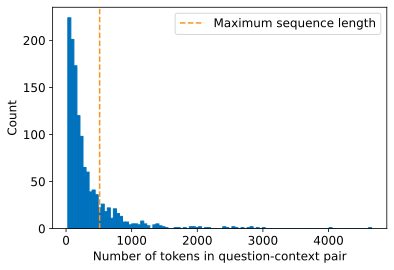

In [27]:
# SubjQA 훈련 세트에 있는 질문-문맥 쌍의 토큰 분포

def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1",
          label="Maximum sequence length") # 수직선 긋기
plt.legend()
plt.ylabel("Count")
plt.show()

텍스트 분류 같은 그 외 작업에서는 정확한 예측을 생성하기 위해 [CLS] 토큰 임베딩에 충분한 정보가 담겼다고 가정하고 그냥 긴 텍스트를 잘랐다.  
하지만 QA 작업에서는 이런 전략이 문제를 일으킨다.  
질문의 답이 문맥의 끝에 있으면 텍스트를 잘랐을 때 답이 삭제된다.  
#### 이 문제를 다루는 전형적인 방법은 입력에 슬라이딩 윈도sliding window를 적용하는 것.  
각 윈도는 모델의 문맥 크기에 맞는 토큰 리스트가 된다.

#### 트랜스포머스는 토크나이저에 return_overflowing_tokens=True를 설정해 슬라이딩 윈도를 만든다.
슬라이딩 윈도의 크기는 max_seq_length 매개변수로, stride의 크기는 doc_stride로 조절한다.  
훈련 세트에 첫 번째 샘플을 사용해 슬라이딩 윈도의 작동 방식을 확인해보자

In [28]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                             return_overflowing_tokens=True, max_length=100,
                             stride = 25)

In [29]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"#{idx} 윈도에는 {len(window)}개의 토큰이 있습니다.")

#0 윈도에는 100개의 토큰이 있습니다.
#1 윈도에는 88개의 토큰이 있습니다.


#### input_ids를 디코딩해 두 윈도가 어디서 겹치는지 확인해보자.

In [30]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and don't feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even
after listening to music with them on all day. the sound is night and day better
than any ear - bud could be and are almost as good as the pro 4aa. they are "
open air " headphones so you cannot match the bass to the sealed types, but it
comes close. for $ 32, you cannot go wrong. [SEP]



이제 QA 모델이 텍스트에서 답을 추출하는 방법을 이해했으니, 엔드-투-엔드 QA 파이프라인을 만드는 데 필요한 다른 구성 요소를 알아보자.

## 7.1.3 헤이스택을 사용해 파이프라인 구축하기

시스템의 실제 사용자는 제품에 대한 질문만 제공한다.  
따라서 말뭉치에 있는 전체 리뷰 중 관련된 텍스트를 선택할 방법이 필요하다.  
이를 수행하는 방법 하나는 해당 제품의 리뷰를 모두 연결해 하나의 긴 문맥으로 만들어 모델에 주입하는 것이다.  이 방법은 간단하지만 문맥이 극도로 길어져 떄로는 사용자 쿼리에 대한 latency를 수용하지 못한다는 단점이 존재  
(답을 구하기 위해 모든 리뷰를 처리한다면 사용자 쿼리마다 수초의 레이턴시가 발생)

#### 최신 QA 시스템은 두 가지 주요 구성 요소로 이루어진 리트리버-리더 retriever-reader 구조를 기반으로 이 문제를 처리한다.

### 리트리버

#### 쿼리에서 관련된 문서를 추출.  
리트리버는 일반적으로 희소 아니면 밀집으로 구분  
희소 리트리버 sparse retriever는 단어 빈도를 사용해 각 문서와 쿼리를 희소 벡터로 표현한다.  
(희소 벡터는 대부분의 원소가 0이다.)  
이 벡트의 내적을 계산해 쿼리와 문서의 관련성을 결정한다.  

반면 밀집 리트리버 dense retriever는 트랜스포머 같은 인코더를 사용해 쿼리와 문서를 문맥화된 임베딩(밀집 벡터)으로 표현한다.  
이런 임베딩이 의미를 인코딩하므로 밀집 리트리버는 쿼리의 내용을 이해해 검색 정확도를 향상시킨다.

### 리더

#### 리트리버가 제공한 문서에서 답을 추출
리더는 대개 독해 모델이지만 이 장의 끝에서 자유 형식의 답변을 생성하는 모델을 살펴볼 예정  

QA 시스템을 만들기 위해, NLP 전문 독일 기업 딥셋(deepset)이 개발한 헤이스택(Haystack) 라이브러리 사용.  
헤이스택은 리트리버-리더 아키텍처를 기반으로 하고, 이런 시스템 구축과 관련된 많은 복잡도를 추상화하며 트랜스포머스와 긴밀하게 통합됐다.

헤이스택으로 QA 파이프라인을 만들 때는 리트리버와 리더 외에 두 가지 구성요소가 더 있다.

### 문서 저장소

쿼리 시점에 리트리버로 제공하는 문서와 메타데이터를 저장하는 문서 전용 데이터베이스

### 파이프라인

사용자 쿼리가 잘 흘러가도록 QA 시스템의 모든 구성 요소를 결합하고 여러 리트리버에서 추출한 문서를 합치는 등의 기능을 한다.

## 문서 저장소 초기화하기

헤이스택에서 사용 가능한 문서 저장소는 다양하며, 저장소마다 조합할 수 있는 전용 리트리버가 있다.

이 장에서는 희소, 밀집 리트리버를 모두 살펴보므로 양쪽 리트리버에 모두 호환되는 ElasticsearchDocumentStore를 사용한다.  
일래스틱서치는 텍스트, 수치, 지리 데이터, 구조적 데이터, 비구조적 데이터를 포함해 다양한 데이터 타입을 처리하는 검색 엔진이다.  
대용량 데이터를 저장하고 전체(full) 텍스트 검색으로 빠르게 필터링하므로 특히 QA 시스템 개발에 잘 맞다.  
인프라 분석을 위한 업계 표준이라는 이점도 있다. -> 회사에는 이미 일래스틱서치 클러스터가 있을 가능성이 높다.

#### 문서 저장소 초기화를 위해 일래스틱서치를 다운로드

In [31]:
# 리눅스 터미널에서 실행 (처음에만)

# wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.9.0-linux-x86_64.tar.gz
# tar -xzf elasticsearch-8.9.0-linux-x86_64.tar.gz
# cd elasticsearch-8.9.0/ 

# sudo chown -R daemon:daemon elasticsearch-8.9.0

### 리눅스 터미널에서 엘라스틱서치 켜기

In [32]:
# import getpass
# import os

# password = getpass.getpass()
# command = "sudo -S wget -nc -q wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-8.9.0-linux-x86_64.tar.gz" #can be any command but don't forget -S as it enables input from stdin
# os.system('echo %s | %s' % (password, command))
# !tar -xzf elasticsearch-8.9.0-linux-x86_64.tar.gz

# password = getpass.getpass()
# command = "sudo -S sudo chown -R daemon:daemon elasticsearch-8.9.0" #can be any command but don't forget -S as it enables input from stdin
# os.system('echo %s | %s' % (password, command))

In [33]:
# import os
# from subprocess import Popen, PIPE, STDOUT

# # 백그라운드 프로세스로 일래스틱서치를 실행합니다
# es_server = Popen(args=['./elasticsearch-8.9.0/bin/elasticsearch'],
#                   stdout=PIPE, stderr=STDOUT) # preexec_fn=lambda: os.setuid(1)은 파이썬 3.8부터 runtime error 때문에 없어짐

### 새 터미널을 열어서 ./bin/elasticsearch 으로 직접 엘라스틱서치를 실행시키자 그냥.  

In [34]:
# 일래스틱서치가 시작할 때까지 기다립니다
!sleep 30

In [35]:
import getpass
import os

# !curl --cacert ./elasticsearch-8.9.0/config/certs/http_ca.crt -u elastic https://localhost:9200
# password = _GlRQRE9bY4tnhiz5Rnb

password = "_GlRQRE9bY4tnhiz5Rnb"
command = "curl --cacert ./elasticsearch-8.9.0/config/certs/http_ca.crt -u elastic https://localhost:9200"
os.system('echo %s | %s' % (password, command))

{
  "name" : "jj-System-Product-Name",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "KxBP9l0FS2e_BdcMHQgGYQ",
  "version" : {
    "number" : "8.9.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "8aa461beb06aa0417a231c345a1b8c38fb498a0d",
    "build_date" : "2023-07-19T14:43:58.555259655Z",
    "build_snapshot" : false,
    "lucene_version" : "9.7.0",
    "minimum_wire_compatibility_version" : "7.17.0",
    "minimum_index_compatibility_version" : "7.0.0"
  },
  "tagline" : "You Know, for Search"
}


Enter host password for user 'elastic':
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   545  100   545    0     0  27247      0 --:--:-- --:--:-- --:--:-- 28684


0

In [36]:
# document_store --> document_stores
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore

# 밀집 리트리버에서 사용할 문서 임베딩을 반환합니다.
document_store = ElasticsearchDocumentStore(host='localhost',
                          port=9200,
                          scheme="https",
                          username="elastic",
                          password="_GlRQRE9bY4tnhiz5Rnb",
                          ca_certs="./elasticsearch-8.9.0/config/certs/http_ca.crt",
                          index= "document",
                          return_embedding=True)

In [37]:
# 노트북을 다시 시작할 때 일래스틱서치 저장소를 모두 비우는 것이 좋습니다.
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [38]:
for split, df in dfs.items():
    # 중복 리뷰를 제외시킵니다
    docs = [{"text": row["context"],
             "meta":{"item_id": row["title"], "question_id": row["id"], "split": split}} 
             for _,row in df.drop_duplicates(subset="context").iterrows()]
             # df.drop_duplicates(subset="context"): 데이터프레임인 df에서 "context" 열을 기준으로 중복된 행을 제거합니다.
             # for _,row in df.drop_duplicates(subset="context").iterrows(): 중복 행이 제거된 데이터프레임 df의 각 행(row)을 반복(iterate)합니다. 여기서 _는 인덱스를 나타내며, 사용하지 않을 것이므로 무시
    document_store.write_documents(docs, index="document")

print(f"{document_store.get_document_count()}개 문서가 저장되었습니다")

1615개 문서가 저장되었습니다


ElasticsearchDocumentStore는 일래스틱 서치에 두 개의 인덱스를 만든다.  
문서를 저장하는 document와 답의 범위를 저장하는 label이다.  
헤이스택 문서 저장소는 text와 meta 키를 가진 딕셔너리의 리스트를 기대한다.

## 리트리버 초기화하기

인덱스를 검색하려면 리트리버가 필요하다.  
일래스틱서치 문서 저장소는 모든 헤이스택 리트리버와 조합이 가능하다.

사용할 BM25는 고전적인 TF-IDF 알고리즘을 개선한 버전으로 일래스틱서치에서 효율적으로 검색할 수 있는 희소 벡터로 질문과 문맥을 표현한다.  
BM25 점수는 검색 쿼리에서 얼마나 많은 텍스트가 일치하는지 측정한다.  
그다음 TF 값을 빠르게 포화시키고 짧은 문서가 긴 문서보다 선호되도록 문서 길이로 정규화해 TF-IDF를 개선한다.

헤이스택에서 ElasticsearchRetriever의 기본 리트리버는 BM25다.  
검색하려는 문서 저장소를 지정해 이 클래스의 객체를 만들어보자

In [39]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

리뷰 기반 QA 시스템에서는 단일 아이템으로 쿼리를 제한하는 것이 중요하다.  
(그렇지 않으면 리트리버가 사용자 쿼리와 무관한 제품의 리뷰도 검색하기 때문) 

예를 들어, 제품 필터링 없이 카메라 성능이 좋냐고 물어봤는데 휴대폰 리뷰가 반환되는 경우가 발생. -> 근데 카메라 성능을 물어본 제품은 랩톱일수도 있다.

데이터셋에 있는 ASIN 값은 암호처럼 보이지만 아마존 ASIN 같은 온라인 도구나 주소 뒤에(www.amazon.com/dp/) item_id 값을 추가하면 해독된다.

In [40]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
                    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

top_k 매개변수로 얼마나 많은 문서를 반환할지 지정하고 문서의 meta 필드에 포함시킨 item_id와 split 키에 모두 필터를 적용했다.  
retreved_docs의 각 원소는 문서를 나타내는 데 사용하는 헤이스택의 Document 객체이고 리트리버의 쿼리 점수와 그 외 메타데이터를 포함한다.

In [41]:
print(retrieved_docs[0]) # [0~2]

{'text': 'This is a gift to myself.  I have been a kindle user for 4 years and
this is my third one.  I never thought I would want a fire for I mainly use it
for book reading.  I decided to try the fire for when I travel I take my laptop,
my phone and my iPod classic.  I love my iPod but watching movies on the plane
with it can be challenging because it is so small. Laptops battery life is not
as good as the Kindle.  So the Fire combines for me what I needed all three to
do. So far so good.', 'score': 6.243799, 'probability': 0.6857824513476455,
'question': None, 'meta': {'item_id': 'B0074BW614', 'question_id':
'868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'embedding': None, 'id':
'252e83e25d52df7311d597dc89eef9f6'}


문서 텍스트 외에, 엘라스틱서치가 쿼리와의 연관성을 계산한 score 필드가 출력된다.(점수가 높을수록 매칭이 더 잘됐음을 의미)  
#### 내부적으로 일래스틱서치는 인덱싱과 검색을 위해 루씬(Lucene)에 의존한다.
따라서 기본적으로 루씬의 "실용적인 스코어링 함수 (practical scoring function)"을 사용한다.  
스코어링 함수는 엘라스틱서치 문서에서 자세히 설명한다.
#### -> 간단히 요약하면 스코어링 함수는 불리언 텍스트boolean text(이 문서가 쿼리에 매칭되는가?)를 사용해 후보 문서를 필터링한 다음
#### 문서와 쿼리의 벡터 표현을 기반으로 유사도를 측정한다.

## 리더 초기화하기

헤이스택에는 주어진 문맥에서 답을 추추랗는 두 종류의 리더가 있다.

1. FARMReader  
-> 트랜스포머를 미세 튜닝하고 배포하는 딥셋의 fARM 프레임워크를 기반으로 함.  
-> 트랜스포머스를 사용해 훈련된 모델과 호환되며 허깅페이스 허브에서 바로 모델을 로드할 수 있다.

2. TransformersReader  
-> 트랜스포머스의 QA 파이프라인을 기반으로 한다.  
-> 추론만 실행하는데 적합하다.

두 리더가 모델의 가중치를 같은 방식으로 처리하지만 예측을 변환해 답을 만드는 방식은 조금 다르다.  

#### 트랜스포머스에서 QA 파이프라인은 각 구절의 시작 로짓과 종료 로짓을 소프트맥스로 정규화한다.  (확률로 만든다고)
따라서 확률의 합이 1이 되는 같은 구절에서 추출한 답의 점수를 비교할 때만 의미 있다.  
예를 들어 한 구절에서 점수가 0.9인 답이, 다른 구절에서 0.8을 얻은 답보다 반드시 더 좋지는 않다.  
FARM에서는 로짓을 정규화하지 않아 구절 간의 답변이 더 쉽게 비교된다.

TransformersReader는 이따금 같은 답을 다른 점수로 두 번 예측한다.  
가령 문맥이 길고 답이 중첩된 윈도에 놓인 경우 그렇다.  
FARM에서는 이런 중복을 제거한다.

이 장의 후반부에서 리더를 미세튜닝하기 위해 FARMReader를 사용한다.  
트랜스포머스와 마찬가지로 모델을 로드하려면 QA 특화된 매개변수와 함께 허깅페이스 허브에 있는 MiniLM 체크포인트를 지정하면 된다.

In [42]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride,
                    return_no_answer=True)

※ 트랜스포머스에서 독해 모델을 직접 미세 튜닝해 추론할 때는 TransformersReader에 로드하는 방법도 있다.  
미세 튜닝 방법에 대한 내용은 허깅페이스 문서 https://oreil.ly/VkhIQ 의 질문 답변 튜토리얼을 참고

FARMReader에서 슬라이딩 윈도의 동작은 토크나이저에서 본 것과 같은 max_seq_length와 doc_stride 매개변수로 제어된다.  
여기서는 MiniLM 논문에 있는 값을 사용함.  
간단한 동작으로 리더를 테스트해보자.

In [43]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648081541061401,
'answers': [{'answer': '6000 hours', 'score': 10.699615478515625, 'probability':
0.3988131284713745, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offset_start': 38, 'offset_end': 48,
'offset_start_in_doc': 38, 'offset_end_in_doc': 48, 'document_id':
'e344757014e804eff50faa3ecf1c9c75'}]}


## 모두 합치기

#### 헤이스택은 리트리버, 리더와 그 외 구성 요소를 연결해 사례에 따라 쉽게 커스터마이징 가능한 그래프로 구성하는 Pipeline 추상화를 제공한다.  
#### 트랜스포머스에 있는 파이프라인과 비슷하지만 QA 시스템에 특화된 사전 정의된 파이프라인도 있다.  

이 경우 답 추출에 관심이 있으므로 매개변수로 하나의 리트리버-리더 쌍을 받는 ExtractiveQAPipeline을 사용하겠다.

In [44]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

각 Pipeline은 쿼리가 어떻게 실행되어야 하는지 지정하는 run() 메서드가 있음.  
ExtractiveQAPipeline의 경우 query, top_k_retriever로 추출할 문서 개수, top_k_reader로 문서에서 추출할 답 개수를 전달한다.  
이 경우 아이템 ID에 대한 필터도 지정해야 한다.  
이는 앞서 리트리버에서 한 것처럼 filters 매개변수를 사용해 처리한다.

아마존 파이어 태블릿에 대한 질문 예를 다시 실행 -> 하지만 이번에는 추출된 답을 반환함.

In [45]:
n_answers = 3
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                    filters={"item_id":[item_id], "split":["train"]})
print(f"질문: {preds['query']} \n")
for idx in range(n_answers):
    print(f"답변 {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"해당 리뷰 텍스트: ...{preds['answers'][idx]['context']}...")
    print("\n\n")

질문: Is it good for reading?

답변 1: I mainly use it for book reading
해당 리뷰 텍스트: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



답변 2: the larger screen compared to the Kindle makes for easier reading
해당 리뷰 텍스트: ...ght enough that I can hold it to read, but the larger screen
compared to the Kindle makes for easier reading. I love the color, something I
never thou...



답변 3: it is great for reading books when no light is available
해당 리뷰 텍스트: ...ecoming addicted to hers! Our son LOVES it and it is great for
reading books when no light is available. Amazing sound but I suggest good
headphones t...





In [46]:
preds

{'query': 'Is it good for reading?',
 'no_ans_gap': 13.715801000595093,
 'answers': [{'answer': 'I mainly use it for book reading',
   'score': 12.282360076904297,
   'probability': 0.3418787121772766,
   'context': ' is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la',
   'offset_start': 59,
   'offset_end': 91,
   'offset_start_in_doc': 132,
   'offset_end_in_doc': 164,
   'document_id': '252e83e25d52df7311d597dc89eef9f6',
   'meta': {'item_id': 'B0074BW614',
    'question_id': '868e311275e26dbafe5af70774a300f3',
    'split': 'train'}},
  {'answer': 'the larger screen compared to the Kindle makes for easier reading',
   'score': 12.188587188720703,
   'probability': 0.34165263175964355,
   'context': 'ght enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the color, something I never thou',
   'offset_start': 43,
   'offset_e

아마존 제품 리뷰를 위한 엔드-투-엔드 QA 시스템 완성!  
시작점으로 괜찮긴 하지만 둘째와 셋째 답변이 실제 묻는 내용에 더 가깝다.  
### 성능을 더 높이려면 리트리버와 리더의 성능을 정량화할 지표가 필요하다.

# 7.2 QA 파이프라인 개선하기

#### 많은 QA 연구가 독해 모델을 개선하는 데 집중하지만 사실 먼저 리트리버가 관련된 문서를 찾지 못한다면 리더의 성능이 얼마나 좋은지는 중요하지 않다.
#### 특히 리트리버는 전체 QA 시스템 성능의 상한선을 설정하므로 리트리버의 성능을 높이는 것이 중요하다.

이런 점을 유념하고 리트리버를 평가해 희소와 밀집 표현의 성능을 비교할 수 있는 일반적인 지표를 몇 가지 소개함

## 7.2.1 리트리버 평가하기

리트리버를 평가하는 일반적인 지표중 하나는 추출된 관련 문서의 비율을 측정하는 recall이다.  
여기서 '관련'이란 표현은 단순히 답이 텍스트 안에 있는지 없는지를 의미한다.  
#### 따라서 일련의 질문이 주어지면 리트리버가 반환한 최상의 k개 문서에 답이 등장한 횟수를 카운트해 재현율을 계산한다.

헤이스택에서 리트리버를 평가하는 방법은 두 가지다.

1. 리트리버가 제공하는 eval() 메서드를 사용한다.  
-> eval()은 오픈 도메인과 클로즈드 도메인 QA에 모두 사용할 수 있다.  
-> 하지만 각 문서가 하나의 제품과 쌍을 이루어 모든 쿼리에서 제품 ID를 필터링해야 하는 SubjQA 같은 데이터셋에서는 사용하지 못한다.
2. EvalDocuments 클래스와 리트리버를 결합하는 사용자 정의 Pipeline을 만든다.  
-> 이를 통해 사용자 정의 지표와 쿼리 흐름을 구현한다.

#### ※ 재현율을 보완하는 지표는 mAP mean Average Precision이다. 문서 순위에서 정답을 높은 위치에 놓은 리트리버에 보상을 제공한다.

#### 제품마다 재현율을 평가하고 그 결과를 수집해야 하므로 두 번째 방법을 사용한다.  
Pipeline 그래프에 있는 각 노드는 어떤 입력을 받고 run() 메서드로 어떤 출력을 만드는 하나의 클래스를 나타낸다.

In [47]:
# class PipelineNode:
#     def __init__(self):
#         self.outgoing_edges = 1
    
#     def run(self, **kwargs):
#         ...
#         return (outputs, "outgoing_edge_name")

여기서 kwargs는 그래프에 있는 이전 노드의 출력에 해당함.  
-> 다음 노드를 위해 출력의 튜플과 노드에서 나가는 edge의 이름을 반환하기 위해 run() 메서드 안에서 처리된다.  
  
이 외에 유일한 요구사항은 노드의 출력 개수를 나타내는 outgoing_edges 속성을 포함하는 것이다. (어떤 조건에 따라 입력을 routing하는 branch가 파이프라인에 없다면, 대부분 outgoing_edges=1이다.)

여기서는 리트리버를 평가할 노드가 필요하다.  
따라서 run() 메서드에서 정답이 있는 문서를 추적하는 EvalDocuments 클래스를 사용.  
그다음 리트리버를 표현한 노드 뒤에 평가 노드를 추가해 Pipeline 그래프를 만든다.

In [48]:
from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(component=self.retriever, name="ESRetriever",
                     inputs=["Query"])
        pipe.add_node(component=self.eval_retriever, name="EvalRetriever",
                     inputs=["ESRetriever"])
        self.pipeline = pipe
        
pipe = EvalRetrieverPipeline(es_retriever)        

각 노드는 name 매개변수와 리스트로 inputs 매개변수를 지정한다.  
대개 노드는 출력에지가 하나다.  
따라서 그냥 inputs에 이전 노드의 이름을 포함시키면 된다.

이제 평가 파이프라인을 만들었으니 쿼리와 이에 해당하는 답을 전달해야 한다.  
이를 위해 문서 저장소에 있는 전용 label 인덱스에 답을 추가해보자.  
헤이스택은 표준 방식으로 답 범위와 메타데이터를 나타내는 Label 객체를 제공한다.  
label 인덱스를 채우기 위해 먼저 테스트 세트에 있는 질문을 순회하면서 답과 추가적인 메타데이터를 추출해 Label 객체의 리스트를 만들어보자.

In [49]:
from haystack import Label

labels = []
for i, row in dfs["test"].iterrows():
    # 리트리버에서 필터링을 위해 사용하는 메타데이터
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # 답이 있는 질문을 레이블에 추가한다.
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                    question=row["question"], answer=answer, id=i, origin=row["id"],
                    meta=meta, is_correct_answer=True, is_correct_document=True,
                    no_answer=False)
            labels.append(label)
    # 답이 없는 질문을 레이블에 추가합니다.
    else:
        label = Label(
                    question=row["question"], answer="", id=i, origin=row["id"],
                    meta=meta, is_correct_answer=True, is_correct_document=True,
                    no_answer=True)
        labels.append(label)

In [50]:
print(labels[0])

{'id': 'ad299275-8394-4f87-a463-151dc9a2d651', 'created_at': None, 'updated_at':
None, 'question': 'What is the tonal balance of these headphones?', 'answer': 'I
have been a headphone fanatic for thirty years', 'is_correct_answer': True,
'is_correct_document': True, 'origin': 'd0781d13200014aa25860e44da9d5ea7',
'document_id': None, 'offset_start_in_doc': None, 'no_answer': False,
'model_id': None, 'meta': {'item_id': 'B00001WRSJ', 'question_id':
'd0781d13200014aa25860e44da9d5ea7'}}


질문 답변 쌍과 쿼리마다 문서 저장소를 필터링할 수 있는 고유한 질문 ID가 담긴 origin 필드가 있다.  
또 제품으로 레이블을 필터링 하기 위해 meta 필드에 제품 ID를 추가했다.  

레이블이 준비됐으니 다음처럼 일래스틱서치의 label 인덱스에 저장한다.

In [51]:
document_store.write_labels(labels, index="label")
print(f"""{document_store.get_label_count(index="label")}개의 \
질문 답변 쌍을 로드했습니다.""")

358개의 질문 답변 쌍을 로드했습니다.


다음으로 파이프라인에 전달하기 위해 질문 ID와 이에 상응하는 답변을 매핑한다.  
전체 레이블을 얻기 위해 문서 저장소의 get_all_labels_aggregated() 메서드를 사용해 고유 ID를 가진 모든 질문-답변 쌍을 가져오자.

이 메서드는 MultiLabel 객체의 리스트를 반환한다.  
하지만 이 예제에서는 질문 ID로 필터링하기 때문에 하나의 원소만 반환된다.

레이블의 리스트를 만드는 코드

In [52]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


레이블 하나를 살펴보면 질문 하나에 연관된 모든 답이 multiple_answer 필드에 들어있다.

#### 리트리버를 평가할 요소를 모두 갖췄다.  
#### 이번에는 각 제품에 연관된 질문-답 쌍을 평가 파이프라인에 주입하고 pipe 객체에서 추출이 올바르게 되는지 추적하는 함수를 정의해보자.

In [53]:
def run_pipeline(pipeline, top_k_retriever=10, top_k_reader=4):
    for l in labels_agg:
        _ = pipeline.pipeline.run(
            query=l.question,
            top_k_retriever=top_k_retriever,
            top_k_reader=top_k_reader,
            top_k_eval_documents=top_k_retriever,
            labels=l,
            filters={"item_id": [l.meta["item_id"]], "split": ["test"]})

In [54]:
run_pipeline(pipe, top_k_retriever=3)
print(f"재현율@3: {pipe.eval_retriever.recall:.2f}")

재현율@3: 0.95


추출한 문서 개수를 위해 top_k_retriever에 특정 값을 지정했다.  
일반적으로 이 매개변수를 증가시키면 재현율이 향상되지만 리더에 더 많은 문서를 제공하는 대가로 엔드 -투-엔드 파이프라인이 느려진다.

#### 어떤 값을 선택할지 결정할 때 도움이 되도록 몇 개의 k 값을 반복하고 각 k에서 전체 테스트 세트의 재현율을 계산하는 함수를 만들어보자.

In [55]:
def evaluate_retriever(retriever, topk_values=[1,3,5,10,20]):
    topk_results = {}
    
    for topk in topk_values:
        # 파이프라인을 만든다.
        p = EvalRetrieverPipeline(retriever)
        # 테스트 세트에 있는 질문-답변 쌍을 반복한다.
        run_pipeline(p, top_k_retriever=topk)
        # 재현율을 저장한다
        topk_results[topk] = {"recall": p.eval_retriever.recall}
    
    return pd.DataFrame.from_dict(topk_results, orient="index")

es_topk_df = evaluate_retriever(es_retriever)

07/31/2023 21:18:03 - INFO - fontTools.subset -   maxp pruned
07/31/2023 21:18:03 - INFO - fontTools.subset -   cmap pruned
07/31/2023 21:18:03 - INFO - fontTools.subset -   kern dropped
07/31/2023 21:18:03 - INFO - fontTools.subset -   post pruned
07/31/2023 21:18:03 - INFO - fontTools.subset -   FFTM dropped
07/31/2023 21:18:03 - INFO - fontTools.subset -   GPOS pruned
07/31/2023 21:18:03 - INFO - fontTools.subset -   GSUB pruned
07/31/2023 21:18:03 - INFO - fontTools.subset -   glyf pruned
07/31/2023 21:18:03 - INFO - fontTools.subset -   Added gid0 to subset
07/31/2023 21:18:03 - INFO - fontTools.subset -   Added first four glyphs to subset
07/31/2023 21:18:03 - INFO - fontTools.subset -   Closing glyph list over 'GSUB': 26 glyphs before
07/31/2023 21:18:03 - INFO - fontTools.subset -   Glyph names: ['.notdef', '.null', 'B', 'M', 'R', 'T', 'a', 'c', 'e', 'eight', 'five', 'four', 'hyphen', 'k', 'l', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'six', 'space', 'three', 'two

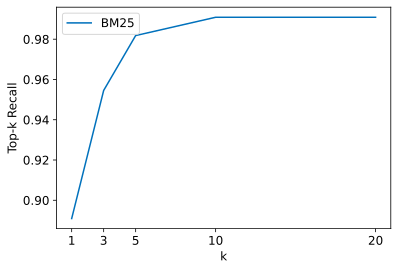

In [56]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

plot_retriever_eval([es_topk_df], ["BM25"])

그래프를 보면 k=5에서 변곡점이 있고 k=10부터 거의 완벽한 재현율을 달성한다.  
#### 그럼 이제 밀집 벡터 기법으로 추출한 문서를 확인해보자.

## DPR

희소 리트리버는 k=10개 문서를 반환할 때 거의 완벽한 재현율을 달성했다.  
하지만 k값이 그보다 작을 때 성능을 높일 방법이 있을까? -> 이렇게 하면 더 적은 수의 문서를 리더로 보내 QA 파이프라인의 전체적인 레이턴시를 줄인다는 이점이 생긴다.  

BM25 같은 희소 리트리버의 주요 단점은 사용자 쿼리의 단어가 리뷰에 들어있지 않으면 연관된 문서를 검색하지 못할 수 있다는 것이다.  
한 가지 희망적인 대안은 밀집 임베딩을 사용해 질문과 문서를 표현하는 것이다.  
DPR(Dense Passage Retrieval)이라 불리는 구조가 현재 최고의 성능을 달성한다.(2020년 기준)

DPR은 두 개의 BERT 모델을 사용해 질문과 구절을 인코딩한다는 개념에 기반한다.

헤이스택에서 DPR을 위한 리트리버를 만드는 방법은 BM25 방법과 비슷하다.  
문서 저장소를 지정하고, 질문과 구절을 위한 BERT 인코더를 선택한다.  
선택한 인코더에 관련된 구절(양성)과 무관한 구절(음성)을 질문과 함께 주입해 훈련한다.

연관된 질문-구절 쌍이 높은 유사도를 가지도록 학습하는 것이 목표다.  
이 예제에서는 NQ 말뭉치에서 미세 튜닝한 인코더를 사용한다.

In [57]:
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
                                     query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
                                     passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
                                     embed_title=False)

제품으로 필터링하므로 문서 제목(즉, item_id)을 연결해 추가 정보를 얻지 못하기 때문에 embed_title=False로 지정함.  
밀집 리트리버를 초기화한 후 다음 단계로 엘라스틱서치에 인덱스된 문서를 모두 순회하면서 인코더를 적용해 임베딩 표현을 업데이트 한다.

In [59]:
document_store.update_embeddings(retriever=dpr_retriever)

07/31/2023 21:18:49 - INFO - haystack.document_store.elasticsearch -   Updating embeddings for all 1615 docs ...


Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

이제 BM25와 같은 방식으로 밀집 리트리버를 평가하고 탑-k 재현율을 비교해보자.

07/31/2023 21:19:56 - INFO - fontTools.subset -   maxp pruned
07/31/2023 21:19:56 - INFO - fontTools.subset -   cmap pruned
07/31/2023 21:19:56 - INFO - fontTools.subset -   kern dropped
07/31/2023 21:19:56 - INFO - fontTools.subset -   post pruned
07/31/2023 21:19:56 - INFO - fontTools.subset -   FFTM dropped
07/31/2023 21:19:56 - INFO - fontTools.subset -   GPOS pruned
07/31/2023 21:19:56 - INFO - fontTools.subset -   GSUB pruned
07/31/2023 21:19:56 - INFO - fontTools.subset -   glyf pruned
07/31/2023 21:19:56 - INFO - fontTools.subset -   Added gid0 to subset
07/31/2023 21:19:56 - INFO - fontTools.subset -   Added first four glyphs to subset
07/31/2023 21:19:56 - INFO - fontTools.subset -   Closing glyph list over 'GSUB': 28 glyphs before
07/31/2023 21:19:56 - INFO - fontTools.subset -   Glyph names: ['.notdef', '.null', 'B', 'D', 'M', 'P', 'R', 'T', 'a', 'c', 'e', 'eight', 'five', 'four', 'hyphen', 'k', 'l', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'six', 'space', 'th

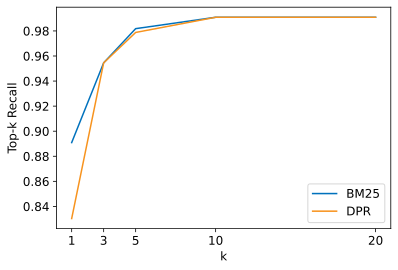

In [60]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([es_topk_df, dpr_topk_df], ["BM25", "DPR"])

그래프를 보면 DPR은 재현율이 BM25보다 높지 않으며 k=3 근방에서 같아진다.

※ 페이스북의 FAISS 라이브러리를 문서 저장소로 사용하면 임베딩의 유사도 검색 속도가 높아진다.  
비슷하게 대상 도메인에서 미세 튜닝을 해도 DPR 리트리버의 성능이 향상된다.  
DPR을 미세 튜닝하는 방법을 알고 싶다면 헤이스택 튜토리얼을 참고할 것.  
https://oreil.ly/eXyro

## 7.2.2 리더 평가하기

#### 추출적 QA에서 리더를 평가하는 주요 지표는 두 가지다
1. EM(Exact Match)  
-> 예측과 정답에 있는 문자가 정확히 일치하면 EM = 1이고 그렇지 않으면 EM = 0인 이진 지표다.  
-> 답이 없다고 예상되면 텍스트를 전혀 예측하지 못하는 것처럼 모델은 EM = 0을 받는다.  
  
2. F1-score  
-> 정밀도와 재현율의 조화평균을 측정

#### FARM에서 헬퍼 함수를 임포트하고 간단한 샘플을 적용해 이런 지표의 작동 방식을 알아보자.

In [61]:
from farm.evaluation.squad_evaluation import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [62]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


내부적으로 이 함수들은  
구두점 삭제, 공백 수정, 소문자 변환을 적용해 먼저 예측과 레이블을 정규화한다.  
그다음 정규화된 문자열을 BoW로 토큰화한다.  
마지막으로 토큰 수준에서 측정 지표를 계산한다.  

EM이 F1-score보다 훨씬 더 엄격한 지표임을 볼 수 있다.  
예측에 토큰이 하나라도 더 추가되면 EM은 0이된다.  
반면 f1-score는 잘못된 답을 잡아내지 못하는 경우도 있다.  
예를 들어 예측한 답이 시간이 아니라 달러를 표시하는 경우가 있다.

f1-score에만 의존하면 결과가 왜곡될 가능성이 존재한다.  
따라서 두 지표를 모두 참고해 모델 성능의 과소평가(EM)와 과대평가(f1-score) 사이에서 균형을 잡는게 좋은 전략이다.

#### 보통 질문에는 유효한 답이 여러 개 있다.
따라서 평가 세트에 있는 각각의 질문-답 쌍에 대해 이런 지표를 계산하고 가능한 답 중에서 가장 좋은 점수를 선택한다.  
그다음 각각의 질문-답 쌍의 개별 점수를 평균해 모델의 전체적인 EM과 f1-score를 구한다.

#### 리더를 평가하기 위해 노드가 두 개(리더 노드와 리더를 평가할 노드)인 새로운 파이프라인을 만들어야 한다.  
리더의 예측을 받아 EM과 f1-score를 계산하는 EvalAnswers 클래스를 사용한다.  
SQuAD 평가와 비교하기 위해 EvalAnswers에 저장된 top_1_em과 top_1_f1 점수로 쿼리마다 최상의 답을 선택한다.

In [63]:
from time import sleep
from haystack.eval import EvalAnswers

def evaluate_reader(reader):
    score_keys = ['top_1_em', 'top_1_f1']
    eval_reader = EvalAnswers(skip_incorrect_retrieval=False)
    pipe = Pipeline()
    pipe.add_node(component=reader, name="QAReader", inputs=["Query"])
    pipe.add_node(component=eval_reader, name="EvalReader", inputs=["QAReader"])

    i = 0
    for l in labels_agg:
        doc = document_store.query(l.question,
                                   filters={"question_id":[l.origin]})
        _ = pipe.run(query=l.question, documents=doc, labels=l)
        i += 1
        sleep(0.01)  # 쿼리 속도를 조절하기 위해

    return {k:v for k,v in eval_reader.__dict__.items() if k in score_keys}

In [64]:
reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

Exception: Exception while running node `QAReader` with input `{'pipeline_type': 'Query', 'query': 'How would you describe the texture of the lens at all focal lengths above 150mm?', 'documents': [{'text': 'UPDATED: 5/20/2011:  I used my D700, and only my 50mm F1.8 to capture my Grandson\'s first haircut!  I posted an image here.  And, on the way home following the haircut, a clearing storm brought some gorgeous bluish-black clouds at dusk so I swung down towards the river and shot a couple of shots with the 50mm.  I posted one here called "Blue Hour".  Enjoy.  Seriously, can\'t go wrong -- though the price seems to be creeping upwards...This 50mm 1.8 is an excellent purchase at around a hundred bucks.  I hate to use the word investment, because we know camera equipment is definitely NOT an investment.  I bought it because I heard so much about it, and, I had a 50mm back in my old film days.  I have not  been disappointed.  I will agree with  many here who say that at F1.8 the results are less than stellar.  This is true--- there is a lack of contrast, not necessarily sharpness (at least in my copy of the lens) that you will notice.  Since I know that as a fact going in to a shoot or session, I set my aperture at F2.0, or F2.2 on my D700, or D300.  This solves the problem.  The resulting images at F 2.0 and above are amazingly sharp, and clear.  Don\'t get me wrong, I love my 16-35F4VR, and my 24-70F2.8 but this 50mm rocks as a standalone lens when the situation demands fast lens.  As a matter of fact, in a few hours I\'m heading off to my grandsons first haircut of his life.  What did I pack?  The D700 (for better high ISO performance than the D300), and my 50mm 1.8.For the price (which seems to have risen lately and rightly so) you can\'t go wrong.  Even if you have other zoom lenses that cover this range as I do, this lens is unbelievably useful in low light to no light situations.  Personally, I\'m lazy and hate zooming with my feet, but I\'d much rather do that with this lens, than either using flash, or blurring photos of important events.The lens finish is plasticy but so what?  Are you going to be banging it around on a regular basis?  My 50mm travels with me just about everywhere either in a camera bag, or in my North Face Recon backpack (not a camera backpack) just about everywhere, and I pump about 80,000 images a year per body, between landscapes, motorsports, portraits, etc.  So far, so good.  It does stand up to a beating.  I do not use any protective filter on it as the glass is relatively well recessed on this lens.When I do need to use filters such as polarizers, or ND\'s, I have step-up rings that take the lens from the 52mm size to 77mm which is the standard size of all my filters. It does look "strange" having the tiny little 50mm lens hidden behind a huge 77mm filter, but it WORKS.Again, if you are looking to make an investment -- there\'s that ugly word again, make that acquisition, to your photo gear you can\'t go wrong at this price point; If you wind up hating it, there\'s always the ability to return it, or sell it on eBay.Enjoy.', 'score': 10.1390915, 'probability': 0.7802950208512726, 'question': None, 'meta': {'item_id': 'B00005LEN4', 'question_id': 'b01740bc2d7f437398dfbb43073398a7', 'split': 'test'}, 'embedding': array([ 3.79402250e-01, -1.50508642e-01,  6.03637695e-01,  4.40367963e-03,
        1.34821609e-01,  2.01575980e-01, -5.57628740e-03, -5.09330034e-02,
       -3.97247046e-01, -4.33257669e-01,  1.11688085e-01,  7.52034783e-01,
       -6.48445338e-02, -1.55836165e-01,  1.64568961e-01,  2.52503604e-01,
        8.64151955e-01,  1.89096168e-01,  1.16973348e-01, -2.40272865e-01,
       -5.05453199e-02, -5.94065189e-01,  2.11371481e-01, -1.67718396e-01,
       -3.62052202e-01, -1.05127528e-01,  3.59382033e-01,  2.19213292e-01,
        1.80828795e-01, -1.21077977e-01, -2.56063879e-01,  3.64603251e-01,
        7.17954040e-02,  2.94559479e-01, -1.32507771e-01, -1.11589804e-01,
       -1.93777993e-01, -2.15732679e-02,  3.71871591e-01,  4.36062217e-02,
       -2.88345724e-01, -1.95262209e-01, -1.50710225e-01,  4.24172962e-04,
       -3.99878085e-01, -4.11807001e-01, -1.52905691e+00, -1.38459742e-01,
       -1.32921562e-02, -1.78664029e-02, -1.37261555e-01, -3.35510857e-02,
       -3.91303718e-01,  3.87135148e-01, -9.95523781e-02,  6.02231026e-01,
       -5.14583409e-01, -5.55847883e-02, -7.45209679e-03, -1.85420454e-01,
        2.47060224e-01, -2.52686143e-01,  2.48015508e-01,  6.51634514e-01,
       -2.62883008e-01,  5.20266354e-01,  2.06058949e-01, -1.48701807e-02,
        1.18909568e-01,  1.27666593e-01,  6.45991445e-01, -1.83119848e-01,
       -6.01145685e-01, -1.89414307e-01, -1.70296043e-01,  1.18028648e-01,
       -2.03434780e-01, -1.73840284e-01,  2.52839714e-01, -7.56606683e-02,
        4.77732003e-01, -8.49875584e-02,  7.83049762e-01, -1.75382882e-01,
        3.82854670e-01,  3.35165739e-01,  2.64895856e-02, -1.90457240e-01,
       -1.28737658e-01,  5.22348762e-01, -3.61883640e-01, -8.69227171e-01,
        4.74815309e-01,  3.49896878e-01,  9.48278308e-02, -2.05717057e-01,
       -1.91989273e-01, -1.14867270e-01,  4.68790710e-01, -2.27253452e-01,
        4.25229251e-01, -3.43435168e-01, -8.37961063e-02, -3.10685575e-01,
       -2.67664671e-01, -2.97048807e-01,  5.10457978e-02, -5.78351259e-01,
        4.93904166e-02,  2.70066857e-01, -4.12501961e-01,  5.43232322e-01,
        2.06477299e-01, -4.88063470e-02, -3.92421484e-01, -3.20408419e-02,
        8.62982124e-02, -2.74572760e-01,  8.88359845e-02,  4.55538601e-01,
        1.73356030e-02,  8.16993713e-01,  4.15819675e-01,  1.31145224e-01,
        3.06123435e-01,  2.91185200e-01,  2.49157295e-01,  8.18811476e-01,
       -5.95510960e-01, -5.97052276e-02,  2.37134501e-01,  3.62355351e-01,
        1.46654835e-02, -1.38454378e-01,  1.40888557e-01, -2.15448588e-01,
        2.87702411e-01, -3.34309161e-01, -3.74116302e-01,  2.76918381e-01,
        7.91279376e-02, -4.21129405e-01, -6.88118279e-01, -4.61244017e-01,
        2.43533865e-01, -3.13191973e-02,  5.58107495e-01,  1.13622703e-01,
        9.16721357e-04,  2.85465848e-02,  2.92088181e-01, -4.54004735e-01,
       -1.20956182e-01, -4.95442599e-01, -3.18111122e-01,  1.11901417e-01,
       -8.93657744e-01, -9.73721817e-02,  2.81256437e-03,  3.17429483e-01,
        5.61526000e-01,  2.00352892e-01, -2.20377177e-01,  1.63309313e-02,
        5.94799280e-01,  9.27844495e-02,  2.74456978e-01,  6.08421862e-03,
        1.45985320e-01, -2.25334987e-01,  3.09654996e-02, -5.64864138e-03,
       -5.79117052e-02, -2.29505032e-01, -1.55063614e-01,  6.90731347e-01,
        5.17606139e-01,  6.36761725e-01, -5.86934164e-02, -3.76051724e-01,
       -6.81357086e-01, -2.88205147e-01,  1.14106461e-01, -2.78296798e-01,
        1.87442109e-01,  2.26977348e-01,  1.65459991e-01,  3.35935593e-01,
        2.05710590e-01,  4.42227483e-01, -4.53106761e-01, -3.27661216e-01,
        3.13201666e-01, -7.65423179e-01,  9.41092908e-01, -2.70611405e-01,
        9.12445318e-03,  1.10437500e+00, -3.09143245e-01,  7.26412892e-01,
        2.44704574e-01, -7.87459090e-02,  4.42339331e-01, -1.13581546e-01,
       -4.81741399e-01,  1.82992399e-01, -7.23098591e-02,  1.79677173e-01,
        1.98966026e-01,  2.83914179e-01,  1.82774812e-01,  1.82649612e-01,
       -2.97228754e-01,  4.29271668e-01,  1.91879153e-01,  6.70161247e-01,
        1.63313150e-01, -6.10508919e-01, -3.75802547e-01, -1.14059977e-01,
        6.58562705e-02,  2.93555915e-01, -1.41396299e-01,  5.32297492e-01,
       -4.08023506e-01,  2.58549899e-01,  6.79427028e-01,  1.51511803e-01,
        4.64872569e-01, -9.29497719e-01, -9.83959660e-02, -1.46294534e-01,
        2.63651907e-01,  7.30417902e-04,  5.86429060e-01,  1.23121060e-01,
        1.72459424e-01, -3.34657937e-01,  5.05217016e-01, -2.08504960e-01,
        6.90842092e-01,  1.00861108e-02, -1.52292661e-02,  3.26930732e-01,
        3.36707503e-01,  3.99590194e-01,  3.40433568e-01,  8.80925298e-01,
       -5.13416827e-01, -7.58660734e-01,  4.17984217e-01,  3.38111401e-01,
        2.29066640e-01, -2.54184067e-01,  1.76023366e-03, -3.91004197e-02,
       -1.34710878e-01,  4.34689602e-04, -5.90617061e-02, -8.41770768e-02,
        1.43010646e-01, -1.49988070e-01,  3.97346824e-01,  6.35029614e-01,
       -3.00174832e-01, -4.82373275e-02, -5.92184365e-01, -2.65526503e-01,
        1.80314288e-01,  2.46345669e-01, -5.00355542e-01,  5.50382316e-01,
       -3.42949331e-01,  6.83517456e-01,  2.84883022e-01, -5.57309687e-01,
        3.85690987e-01,  4.91206586e-01, -5.45148402e-02, -1.89050093e-01,
        2.11421549e-01,  5.07634819e-01,  2.10761085e-01,  9.92657468e-02,
       -9.51782942e-01, -8.23731303e-01,  2.10598826e-01, -3.28610949e-02,
       -5.36385596e-01, -2.61268079e-01,  2.47407809e-01,  2.29015291e-01,
       -8.06831345e-02,  1.00659326e-01,  7.53028095e-01,  2.81801343e-01,
        1.08594604e-01, -3.23255695e-02,  1.63324520e-01,  4.98131104e-02,
        2.16402456e-01,  5.37533402e-01,  5.24981618e-01, -5.08319438e-02,
        2.41711020e-01, -2.32358307e-01, -4.17283595e-01, -3.64165336e-01,
       -5.94404411e+00,  2.60506928e-01, -3.15348595e-01, -1.44276977e-01,
       -6.37034595e-01, -6.15540780e-02,  7.07736492e-01,  1.76005010e-02,
        3.44250262e-01, -1.55291930e-01,  3.08438838e-01,  9.55024585e-02,
        1.80042833e-01, -3.37971263e-02, -3.44814450e-01,  6.10329032e-01,
        5.92218220e-01,  4.46257681e-01, -2.29625314e-01,  1.64078176e-01,
       -4.51712281e-01, -1.91011354e-01,  1.90758437e-01,  2.24081218e-01,
        5.43600082e-01, -8.39352459e-02, -7.85431325e-01,  2.48326302e-01,
       -1.69911563e-01, -1.28167361e-01,  3.53571206e-01, -3.36812913e-01,
        2.05063224e-01,  3.42305303e-01,  1.10233545e-01,  5.44960439e-01,
       -6.87650964e-02,  6.34051263e-02,  2.15219170e-01, -6.31509960e-01,
        3.99988860e-01,  6.29128814e-01, -9.65741575e-02, -1.01032458e-01,
       -1.39863163e-01, -1.86421797e-01, -1.41609624e-01, -2.12427765e-01,
       -1.10450208e-01,  6.63825631e-01, -3.10773224e-01, -3.08954060e-01,
        1.29858404e-01,  3.40562880e-01,  9.09029786e-03, -2.70833224e-01,
       -1.98690733e-03,  5.02727568e-01,  1.58576831e-01,  1.56290576e-01,
        1.04727030e-01, -1.53457791e-01,  1.61166087e-01, -5.63028753e-01,
        1.72606945e-01, -1.62392259e-01, -8.15788746e-01, -5.66437602e-01,
        2.64440030e-01,  3.53830129e-01, -1.54195100e-01,  1.81332305e-01,
        1.13618374e-01, -9.11053240e-01,  1.45827997e-02, -5.35053015e-01,
        4.82655689e-02,  1.43415362e-01, -6.43172979e-01,  2.36714482e-01,
        7.86137819e-01, -4.17777210e-01,  2.41020948e-01,  4.48376447e-01,
        2.93397039e-01, -5.03073215e-01, -2.70465054e-02, -3.37758690e-01,
        1.11442789e-01, -6.76988363e-02,  1.24317932e+00, -2.24569544e-01,
       -5.52732646e-02, -2.66241789e-01, -2.77489960e-01,  2.94802841e-02,
        1.63572535e-01, -2.18273267e-01,  3.47524703e-01, -4.31484789e-01,
        9.72109616e-01,  1.44834593e-01,  2.66359821e-02, -9.39124465e-01,
       -2.35566735e-01,  3.68215553e-02, -3.47257048e-01,  1.89640984e-01,
        5.31670630e-01, -7.37204731e-01, -4.17681009e-01, -8.39397132e-01,
        1.99593306e-02, -1.72579005e-01,  2.25274220e-01, -5.40193915e-01,
       -1.90663129e-01, -1.63752824e-01,  2.43611764e-02, -3.10952693e-01,
        3.04003268e-01, -1.10992700e-01, -6.01817250e-01, -7.22513735e-01,
       -3.60563695e-01, -1.01961516e-01, -4.01700884e-01,  3.86895090e-01,
       -4.87607926e-01,  2.15908676e-01,  1.59470811e-01,  4.49586481e-01,
       -1.06111117e-01,  7.29565918e-02,  3.38412523e-01, -5.12764752e-01,
       -2.18122661e-01, -1.75527394e-01,  3.01886976e-01, -1.59286305e-01,
       -6.48865625e-02,  4.05521952e-02,  8.25491324e-02, -8.20409507e-02,
        5.16729616e-02,  3.71367246e-01,  1.28861636e-01, -2.28971481e-01,
       -9.68757987e-01,  3.01846772e-01,  1.29994065e-01, -4.45246547e-01,
       -5.81206568e-02,  3.14839892e-02, -4.20551300e-01,  3.95021617e-01,
       -2.14918870e-02,  2.48090252e-01, -3.39756869e-02, -3.62934232e-01,
        8.05915177e-01,  3.16540524e-02, -7.58924305e-01,  2.53657848e-01,
        8.00256431e-01, -4.34356481e-02, -9.93727073e-02, -9.33450162e-01,
        1.46621978e-02,  2.15206400e-01, -6.98648468e-02, -2.06287518e-01,
       -6.37663603e-01, -4.74498510e-01,  6.18376255e-01,  2.91858524e-01,
       -8.66927654e-02, -1.18350245e-01,  4.72814530e-01, -4.46638554e-01,
        7.22059757e-02, -2.61820436e-01, -4.77566481e-01,  1.25339374e-01,
        2.49769241e-01, -2.84097970e-01, -2.43788883e-01, -2.77308434e-01,
       -5.52229583e-01, -2.56505340e-01,  9.83615279e-01,  4.47761029e-01,
        3.64789695e-01,  3.01041573e-01, -1.16553336e-01, -9.21786129e-01,
        5.48254736e-02, -2.65896805e-02, -2.27277622e-01, -8.81246477e-02,
       -4.60513197e-02,  4.77740586e-01, -5.09438634e-01,  5.86262643e-01,
        7.36810327e-01, -2.97864676e-02,  4.92563069e-01,  4.59347427e-01,
       -6.65528953e-01,  3.12737852e-01,  2.32169420e-01, -9.53554332e-01,
       -4.01002198e-01, -1.63571015e-02,  3.42758037e-02,  3.41951102e-01,
        2.90872902e-01, -5.29557884e-01, -5.49290299e-01, -2.45426401e-01,
        3.11063170e-01, -2.39515021e-01, -4.85175967e-01, -2.28703227e-02,
       -2.90080309e-01, -1.19474389e-01,  5.79751492e-01, -1.01741552e-02,
       -3.56614202e-01, -2.56009072e-01, -5.28683424e-01,  1.28524795e-01,
        6.13080740e-01,  2.49989688e-01, -4.45252180e-01,  2.22147942e-01,
       -7.92007148e-01,  1.95856467e-01,  6.11094870e-02,  5.06713748e-01,
        6.96348175e-02,  3.64800751e-01, -3.55300993e-01, -5.63327551e-01,
       -9.50430095e-01,  1.99917927e-01, -3.46643865e-01,  1.63237125e-01,
       -8.02896738e-01,  3.53429973e-01, -3.51135321e-02, -2.12475866e-01,
        5.34698606e-01, -1.59293503e-01,  3.78077507e-01, -5.61681747e-01,
        1.98116109e-01, -7.41930157e-02,  1.71879716e-02,  4.09997076e-01,
       -2.13769823e-03,  1.35650933e-01, -6.00528300e-01, -1.81555197e-01,
        5.75765371e-01,  4.80020374e-01, -4.76954937e-01, -4.63374674e-01,
        6.06466969e-03, -1.17703177e-01, -3.38760078e-01,  4.72918749e-02,
        1.89188689e-01,  9.63837430e-02,  7.44324401e-02, -2.05306053e-01,
       -8.32318306e-01,  3.16085041e-01, -3.72391343e-01, -1.66271284e-01,
       -2.65243314e-02,  6.81187138e-02,  1.83569729e-01, -2.61047632e-01,
       -4.08688515e-01, -2.73665786e-01,  8.82462710e-02,  1.35676995e-01,
       -3.97506982e-01,  1.29917711e-01, -2.45327100e-01,  3.97108972e-01,
       -4.57077265e-01, -3.78906317e-02,  2.74766684e-01,  6.64629698e-01,
        2.77685881e-01,  2.18883991e-01, -5.02329409e-01,  1.16702817e-01,
        5.79850316e-01,  6.12053514e-01,  4.19298321e-01,  1.41748026e-01,
        8.93658027e-02,  3.81537706e-01,  5.62949657e-01, -1.67574883e-01,
       -2.52547652e-01,  5.63057423e-01,  5.31525612e-01, -1.58280283e-02,
       -2.06571862e-01,  8.02114725e-01, -7.30551898e-01, -3.69849414e-01,
        2.05849066e-01,  2.46123418e-01, -2.20498174e-01, -1.01109520e-01,
        3.26867849e-01,  3.73433501e-01,  2.03200221e-01,  2.16329098e-01,
       -1.29662049e+00,  4.22174275e-01, -7.97875300e-02,  4.05048430e-01,
        3.31127375e-01,  4.37466919e-01,  3.71652067e-01,  4.76019859e-01,
       -4.25159782e-01,  3.90353352e-01, -8.74196440e-02,  4.12720829e-01,
        2.92008668e-01, -5.01852036e-01, -2.89152920e-01,  8.38732347e-02,
        5.99225581e-01,  6.73246980e-01,  4.22539152e-02,  5.59462700e-04,
       -2.82994807e-01,  2.31242195e-01,  2.09663749e-01, -4.35211122e-01,
        3.10273916e-01, -5.99828303e-01, -3.00033092e-02, -1.20884307e-01,
       -4.38467748e-02, -5.82723379e-01, -1.41716406e-01, -1.08480953e-01,
       -2.23028809e-02, -7.52198279e-01, -4.85587746e-01,  4.35133278e-02,
        2.31962994e-01,  1.30490974e-01, -1.37738168e-01, -5.09414002e-02,
       -4.58808243e-01, -3.00982088e-01,  1.34997889e-01,  3.80095601e-01,
       -4.98122014e-02, -3.66467498e-02, -2.61878937e-01,  3.22702169e-01,
       -1.98281810e-01, -3.67293745e-01,  1.53731748e-01, -2.27309182e-01,
        4.04372573e-01, -3.53231668e-01,  1.69757545e-01,  9.20328915e-01,
       -1.87360078e-01,  3.43679190e-01, -4.95476663e-01, -5.62623560e-01,
        3.04405540e-01, -1.94621205e-01,  2.19995752e-01,  2.77629442e-04,
       -4.16438691e-02, -6.38861537e-01, -9.76967663e-02, -1.37061679e+00,
       -6.98749959e-01,  2.53440380e-01, -3.85740191e-01, -5.89954138e-01,
       -7.54175410e-02,  5.24529159e-01,  2.62163162e-01,  5.72723627e-01,
       -1.34087456e-02, -3.12629431e-01,  3.41327749e-02,  6.76002860e-01,
        1.84571028e-01,  2.03503117e-01, -6.81973040e-01,  2.98446149e-01,
       -1.84225693e-01,  3.82800847e-01,  6.08432293e-01, -3.97763848e-01,
        3.17179598e-02, -3.67621183e-02, -1.77840084e-01, -1.10143900e-01,
        5.96942425e-01, -2.44038060e-01, -2.51332372e-01, -5.98331332e-01,
       -2.55428851e-01, -5.50883353e-01,  1.98598847e-01, -2.01967009e-03,
        2.87152287e-02, -3.76025736e-02, -2.29593843e-01,  3.48930568e-01,
       -3.08766216e-01,  1.99529499e-01, -1.08805746e-02, -3.93394470e-01,
       -3.01252663e-01,  2.68242508e-01, -8.62208664e-01,  5.91253750e-02,
        4.55404550e-01,  2.36248359e-01,  4.29214686e-02,  1.61049113e-01,
       -4.56864983e-01,  2.38776095e-02,  3.45819056e-01,  3.85676235e-01,
        3.36621446e-03,  2.76421309e-02, -7.46260703e-01, -2.80230850e-01,
       -7.90523946e-01,  3.38399783e-02,  5.36107495e-02, -1.55407473e-01,
       -1.46609157e-01, -3.08161378e-01,  5.06603643e-02, -7.84133002e-02,
       -3.15559715e-01, -5.46590745e-01,  1.95482955e-03, -6.06725991e-01],
      dtype=float32), 'id': 'bfc12eb1e276cba28e48df81489899ba'}], 'labels': {'question': 'How would you describe the texture of the lens at all focal lengths above 150mm?', 'multiple_answers': [''], 'is_correct_answer': True, 'is_correct_document': True, 'origin': 'b01740bc2d7f437398dfbb43073398a7', 'multiple_document_ids': [None], 'multiple_offset_start_in_docs': [None], 'no_answer': True, 'model_id': None, 'meta': {'item_id': 'B00005LEN4'}}, 'node_id': 'QAReader'}`: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`, full stack trace: Traceback (most recent call last):
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/haystack/pipeline.py", line 131, in run
    node_output, stream_id = self.graph.nodes[node_id]["component"].run(**node_input)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/haystack/reader/base.py", line 58, in run
    results = predict(query=query, documents=documents, top_k=top_k_reader)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/haystack/reader/base.py", line 79, in wrapper
    ret = fn(*args, **kwargs)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/haystack/reader/farm.py", line 384, in predict
    predictions = self.inferencer.inference_from_objects(
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/farm/infer.py", line 707, in inference_from_objects
    return self.inference_from_dicts(dicts, return_json=return_json,
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/farm/infer.py", line 688, in inference_from_dicts
    return Inferencer.inference_from_dicts(self, dicts, return_json=return_json,
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/farm/infer.py", line 456, in inference_from_dicts
    return list(predictions)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/farm/infer.py", line 536, in _inference_with_multiprocessing
    predictions = self._get_predictions_and_aggregate(
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/farm/infer.py", line 624, in _get_predictions_and_aggregate
    logits = self.model.forward(**batch)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/farm/modeling/adaptive_model.py", line 419, in forward
    sequence_output, pooled_output = self.forward_lm(**kwargs)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/farm/modeling/adaptive_model.py", line 463, in forward_lm
    sequence_output, pooled_output = self.language_model(**kwargs, return_dict=False, output_all_encoded_layers=False)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/farm/modeling/language_model.py", line 506, in forward
    output_tuple = self.model(
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/models/bert/modeling_bert.py", line 971, in forward
    encoder_outputs = self.encoder(
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/models/bert/modeling_bert.py", line 568, in forward
    layer_outputs = layer_module(
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/models/bert/modeling_bert.py", line 456, in forward
    self_attention_outputs = self.attention(
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/models/bert/modeling_bert.py", line 387, in forward
    self_outputs = self.self(
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/models/bert/modeling_bert.py", line 253, in forward
    mixed_query_layer = self.query(hidden_states)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/torch/nn/modules/linear.py", line 94, in forward
    return F.linear(input, self.weight, self.bias)
  File "/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/torch/nn/functional.py", line 1753, in linear
    return torch._C._nn.linear(input, weight, bias)
RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`
